# Lab 3: Face Morphing using Delaunay Triangulation

ในแล็บนี้เราจะศึกษา Application ของ Non-Parametric Transformation ในการเปลี่ยน/สลับใบหน้าในรูป (Face Morphing)  จุดเด่นของ  Non-Parametric Transformation คือ สามารถแปลงภาพในแต่ละส่วนด้วยรูปแบบที่ต่างกันได้ แต่ผลที่ตามมาก็คือการคำนวณที่ซับซ้อนขึ้น

โดยวิธี Non-Parametric Transformation  ที่จะใช้ในแล็บนี้ จะเริ่มจากแบ่งภาพออกเป็นส่วน ๆ ในตำแหน่งเดียวกันบนวัตถุ/ใบหน้าในภาพ แล้วทำ Affine Transformation ในภาพแต่ละส่วน &nbsp;&nbsp; ในการแบ่งภาพจะใช้วิธี Delaunay Triangulation [2]  ซึ่งจะแบ่งภาพเป็นสามเหลี่ยมย่อย ๆ เหตุที่ใช้สามเหลี่ยมเพราะไม่มีปัญหาเรื่องรูปหลายเหลี่ยมที่มีด้านตัดกันเอง (Self-Intersecting) &nbsp;&nbsp; และการระบุตำแหน่งบนใบหน้าจะใช้วิธีกำหนด
จุดสังเกต (Landmarks) ด้วยมือบนภาพใบหน้าทั้งสองที่ต้องการสลับใบหน้ากัน เพิ่อให้ง่ายต่อการใช้งาน แทนที่จะต้องกำหนดบริเวณของภาพที่มีวัตถุ/ส่วนของใบหน้าเดียวกันซึ่งทำด้วยมือได้ยากกว่า โดยใบหน้าก็มักจะใช้บริเวณตา จมูก ปาก คิ้ว และใบหน้า เป็นจุดสังเกต อย่างในชุดข้อมูล [300 Faces In-the-Wild Challenge (300-W)](https://ibug.doc.ic.ac.uk/resources/300-W/) ใช้จุดสังเกตจำนวน 68 จุด ดังในภาพ

<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*_L1MBDYku0pX0T7_-BVCfA.png" alt= "Face Landmarks" width="650px">

***ในแล็บนี้ เราจะมาดูวิธีการ Implement การสลับใบหน้าในรูป (Face Morphing) ด้วยวิธี Delaunay Triangulation*** ซึ่งมีขั้นตอนดังนี้
1. **Defining Correspondences** การแบ่งภาพทั้งสองที่ต้องการสลับใบหน้ากันออกเป็นส่วน ๆ และให้แต่ละส่วนสอดคล้องกัน (Correspondences)  หรือเป็นส่วนของวัตถุ/ส่วนของใบหน้าเดียวกัน โดยใช้ Face Landmarks จากชุดข้อมูล [300 Faces In-the-Wild Challenge (300-W)](https://ibug.doc.ic.ac.uk/resources/300-W/) และแบ่งภาพเป็นส่วน ๆ ด้วยวิธี Delaunay Triangulation
2. **Morphing** ทำ Affine Transformation กับแต่ละสามเหลี่ยมย่อย ๆ ของภาพ จนได้ภาพผลลัพธ์

<img src="https://miro.medium.com/v2/resize:fit:2000/format:webp/1*zLMvfOhkoeXRAZr6kT9jkA.png" alt= "Face Morphing" width="650px">


**References**
1. https://devendrapratapyadav.github.io/FaceMorphing/
2. https://en.wikipedia.org/wiki/Delaunay_triangulation

## 0. Prepare Dataset

ทำการดาวน์โหลดภาพตัวอย่าง พร้อม Face Landmarks จากชุดข้อมูล 300 Faces In-the-Wild Challenge (300-W) (https://ibug.doc.ic.ac.uk/resources/300-W/) โดยข้อมูล Face Landmarks จะอยู่ในรูป Text File ในไฟล์ `.pts` ที่แต่ละบรรทัดจะบันทึกตำแหน่ง X, Y ของจุด Landmarks แต่ละจุด

In [ ]:
!wget -O "face_landmarks.zip" https://drive.google.com/uc?id=1cByEEoWooh-dBdCFVseGLyUMNhx6lpNL&export=download

--2023-05-24 04:07:57--  https://drive.google.com/u/1/uc?id=1cByEEoWooh-dBdCFVseGLyUMNhx6lpNL
Resolving drive.google.com (drive.google.com)... 172.217.214.139, 172.217.214.101, 172.217.214.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1cByEEoWooh-dBdCFVseGLyUMNhx6lpNL [following]
--2023-05-24 04:07:57--  https://drive.google.com/uc?id=1cByEEoWooh-dBdCFVseGLyUMNhx6lpNL
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ik6bpcpsjvvnd487gsml2i8n0qq276p3/1684901250000/11797005964751114850/*/1cByEEoWooh-dBdCFVseGLyUMNhx6lpNL?uuid=5a52422b-05ba-49e0-88e5-7d29746a7488 [following]
--2023-05-24 04:07:58--  https://doc-0k-6o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ik6bpc

In [ ]:
!unzip -o face_landmarks.zip

Archive:  face_landmarks.zip
  inflating: indoor_025.png          
  inflating: indoor_025.pts          
  inflating: indoor_027.png          
  inflating: indoor_027.pts          


In [ ]:
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
%matplotlib inline

## 1. Defining Correspondences

ทำการอ่านภาพ และอ่านตำแหน่งของจุด Landmark บนใบหน้า ของภาพทั้งสอง

In [ ]:
img1 = cv2.imread("indoor_025.png", cv2.IMREAD_COLOR)
img2 = cv2.imread("indoor_027.png", cv2.IMREAD_COLOR)

In [ ]:
def read_pts(fn):
    with open(fn, 'r') as f:
        coord = []
        for s in f.readlines():
            r = re.search("(?P<x>[0-9]*[.,][0-9]*) (?P<y>[0-9]*[.,][0-9]*)", s)
            if r:
                coord.append([float(r.group('x')), float(r.group('y'))])
    return np.array(coord)

coord1 = read_pts('indoor_025.pts')
coord2 = read_pts('indoor_027.pts')

ทำการแบ่งภาพเป็นรูปสามเหลี่ยมย่อย ๆ ด้วยวิธี Delaunay Triangulation โดยเรียกใช้ฟังก์ชัน [`Delaunay`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html) ใน `SciPy` ซึ่งจะระบุตำแหน่งของรูปสามเหลี่ยมต่าง ๆ ด้วย Index ของจุด Landmarks ดังนั้นเราจึงคำนวณแค่ครั้งเดียว แล้วใช้ตำแหน่งของสามเหลี่ยมเดียวกันกับทั้งสองภาพ โดยตำแหน่งของสามเหลี่ยมที่ได้จากวิธี Delaunay Triangulation จะไม่มีภาพสามเหลี่ยมที่ทับกัน แต่ต่อกันพอดี (ใช้ด้านเดียวกัน) และครอบคลุมกรอบด้านนอก หรือ Convex Hull ของจุด Landmarks ทั้งหมด

![](https://ars.els-cdn.com/content/image/3-s2.0-B9781785482434500050-f05-07-9781785482434.jpg)

In [ ]:
tri = Delaunay(coord1)

แสดงภาพทั้งสอง พร้อมจุด Face Landmarks และส่วนของภาพที่ถูกแบ่งด้วยวิธี Delaunay Triangulation โดยใช้ฟังก์ชัน [`triplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.triplot.html) ในการแสดงส่วนของภาพที่ถูกแบ่ง

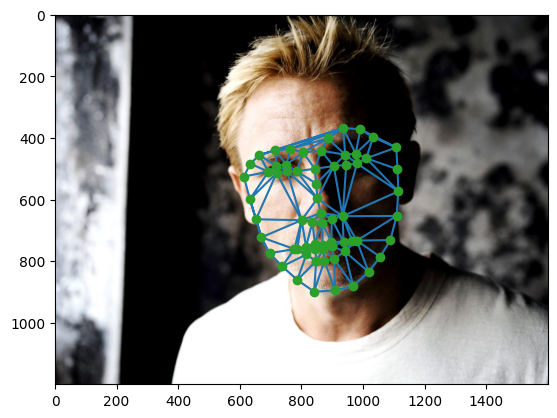

In [ ]:
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)/255)
plt.triplot(coord1[:,0], coord1[:,1], tri.simplices)
plt.plot(coord1[:,0], coord1[:,1], 'o')
plt.show()

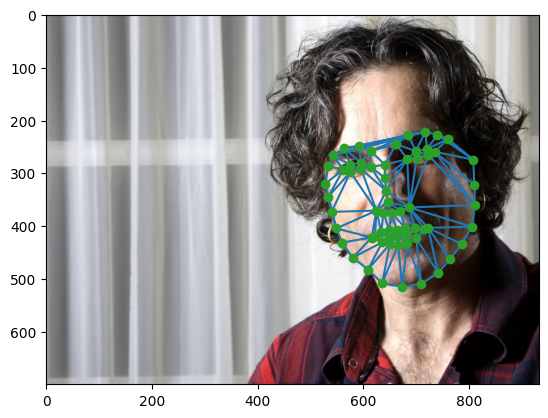

In [ ]:
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)/255)
plt.triplot(coord2[:,0], coord2[:,1], tri.simplices)
plt.plot(coord2[:,0], coord2[:,1], 'o')
plt.show()

## 2. Morphing

ทำ Affine Transformation กับแต่ละสามเหลี่ยมย่อย ๆ ของภาพ ซึ่งมีขั้นตอนดังนี้
1. หา Bounding Box หรือกรอบสีเหลี่ยมที่ตั้งฉากกับแกน X และ Y ของรูปสามเหลี่ยมย่อย ด้วยฟังก์ชัน `boundingRect` เนื่องจากข้อมูลรูปภาพถูกจัดเก็บในรูปของตาราง จึงต้องอัพเดทโดยการระบุแถวและคอลัมน์ และฟังก์ชัน Transformation รองรับภาพสี่เหลี่ยมเท่านั้น
2. หา Mask หรือ ภาพ binary ที่ระบุบริเวณของรูปสามเหลี่ยมย่อย ด้วยฟังก์ชัน `fillConvexPoly`
3. ทำ Affine Transformation บนรูปสามเหลี่ยมย่อย โดยจะต้องคำนวณ Transformation Matrix ด้วยฟังก์ชัน `getAffineTransform` ก่อน แล้วจึงแปลงภาพด้วยฟังก์ชัน `warpAffine`
4. อัพเดทภาพในบริเวณ Mask เท่านั้น

In [ ]:
def apply_affine_transform(src, src_tri, target_tri, size):
    warp_mat = cv2.getAffineTransform(np.float32(src_tri), np.float32(target_tri))
    dst = cv2.warpAffine(src, warp_mat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR,
                         borderMode=cv2.BORDER_REFLECT_101)
    return dst

In [ ]:
face = np.zeros(img2.shape, dtype=np.float32)
img = img2.copy()
i = 0
# morph each triangle
for t in tri.simplices:
    t1 = coord1[t]
    t2 = coord2[t]

    # find bounding box
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    t1_rect = []
    t2_rect = []

    for i in range(0, 3):
        t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
        t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

    # find mask of triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2_rect), (1.0, 1.0, 1.0), 16, 0)

    img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2_rect = img2[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

    # apply affine transformation
    size = (r2[2], r2[3])
    warp_image1 = apply_affine_transform(img1_rect, t1_rect, t2_rect, size)

    # update image over mask's area
    face[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] += warp_image1 * mask
    img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * (1 - mask) + warp_image1 * mask

แสดงภาพใบหน้าที่ได้จากการ Morphing

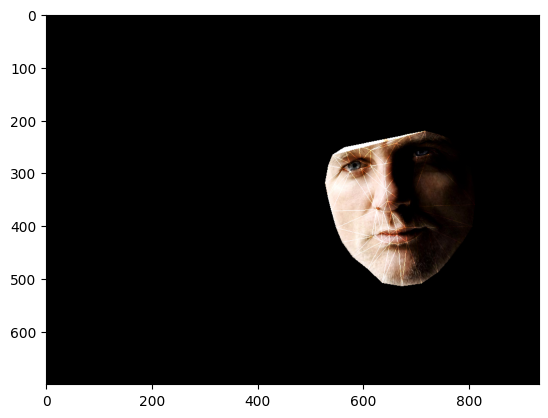

In [ ]:
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB)/255)

เปรียบเทียบภาพเดิมทั้งสอง และภาพผลลัพธ์ที่ได้หลังจากทำ Face Morphing ซึ่งจะเห็นว่าภาพใบหน้าถูกสลับกันแล้ว

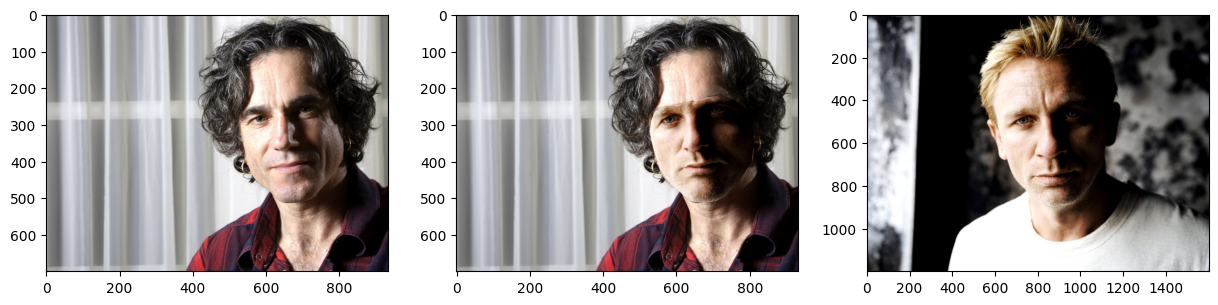

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)/255)
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)/255)

----